# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing libraries and data

In [1]:
conda install quandl

Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles statistical models
import os
import warnings # This is a library that handles warnings

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, a suspended library or feature

plt.style.use('fivethirtyeight') # This is a styling option for how plots will appear

In [3]:
# Configure API key 

quandl.ApiConfig.api_key = 'yXJs-PVs6c5C-mHC2HFM'

In [4]:
# Importing the Federal Reserve Economic Data "Civilian Unemployment Rate" variable

data = quandl.get('FRED/UNRATE')

In [5]:
data.head(5)

,Value
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [6]:
data.shape

(889, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

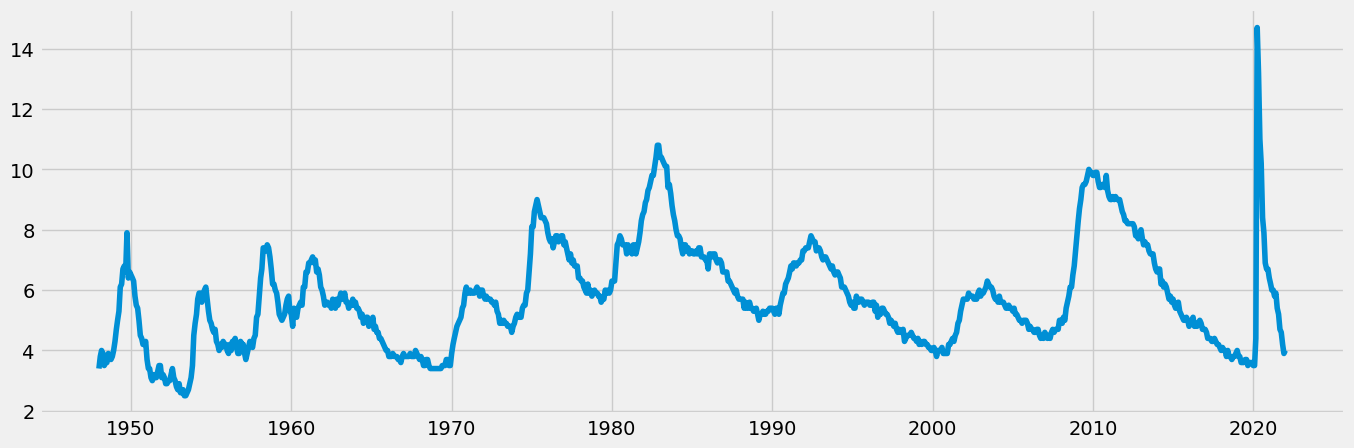

In [9]:
# Plot the data using matplotlib

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100, it will produce lower-than-standard quality

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [10]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [12]:
data_sub = data_2.loc[(data_2['Date'] >= '2019-01-01') & (data_2['Date'] < '2023-03-01')]

In [13]:
data_sub.shape

(37, 2)

In [14]:
data_sub.head()

,Date,Value
852,2019-01-01,4.0
853,2019-02-01,3.8
854,2019-03-01,3.8
855,2019-04-01,3.6
856,2019-05-01,3.6


In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2019-01-01,4.0
2019-02-01,3.8
2019-03-01,3.8
2019-04-01,3.6
2019-05-01,3.6


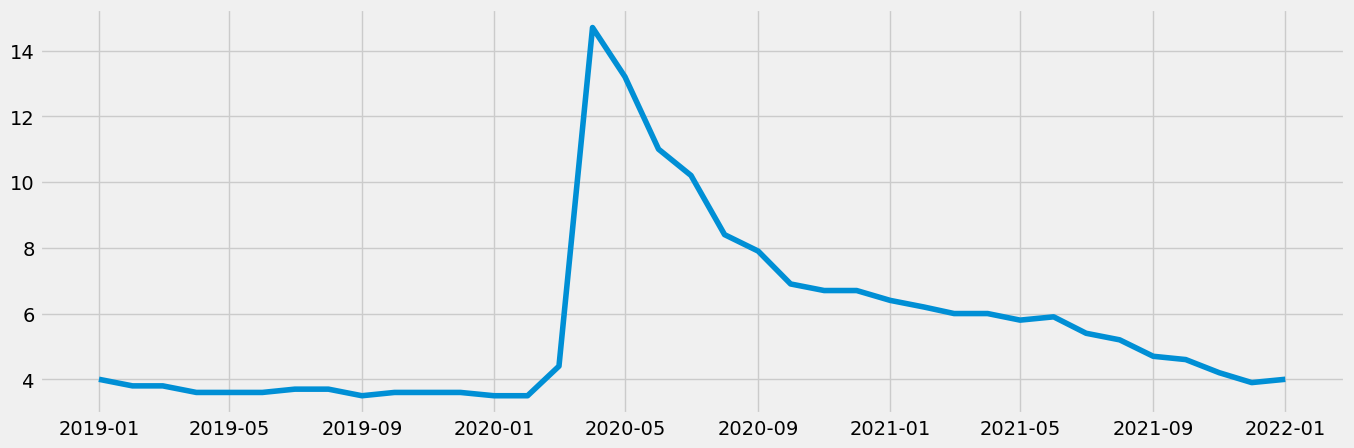

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [18]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

12

### The PPP loan program was originally created in March 2020 to help small businesses during the pandamic. Businesses were struggling during this time because of global quarantine which led to furloughs and in many cases unemployment. For this reason, this data set provides an insight into the spike in civilian unemployment rates, beginning in 2019 to show a prior trend and continuing all the way to the beginning of 2022.

### 3. Time-series analysis: decomposition

In [19]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
from pylab import rcParams # This will define a fixed size for all special charts

rcParams['figure.figsize'] = 18, 7

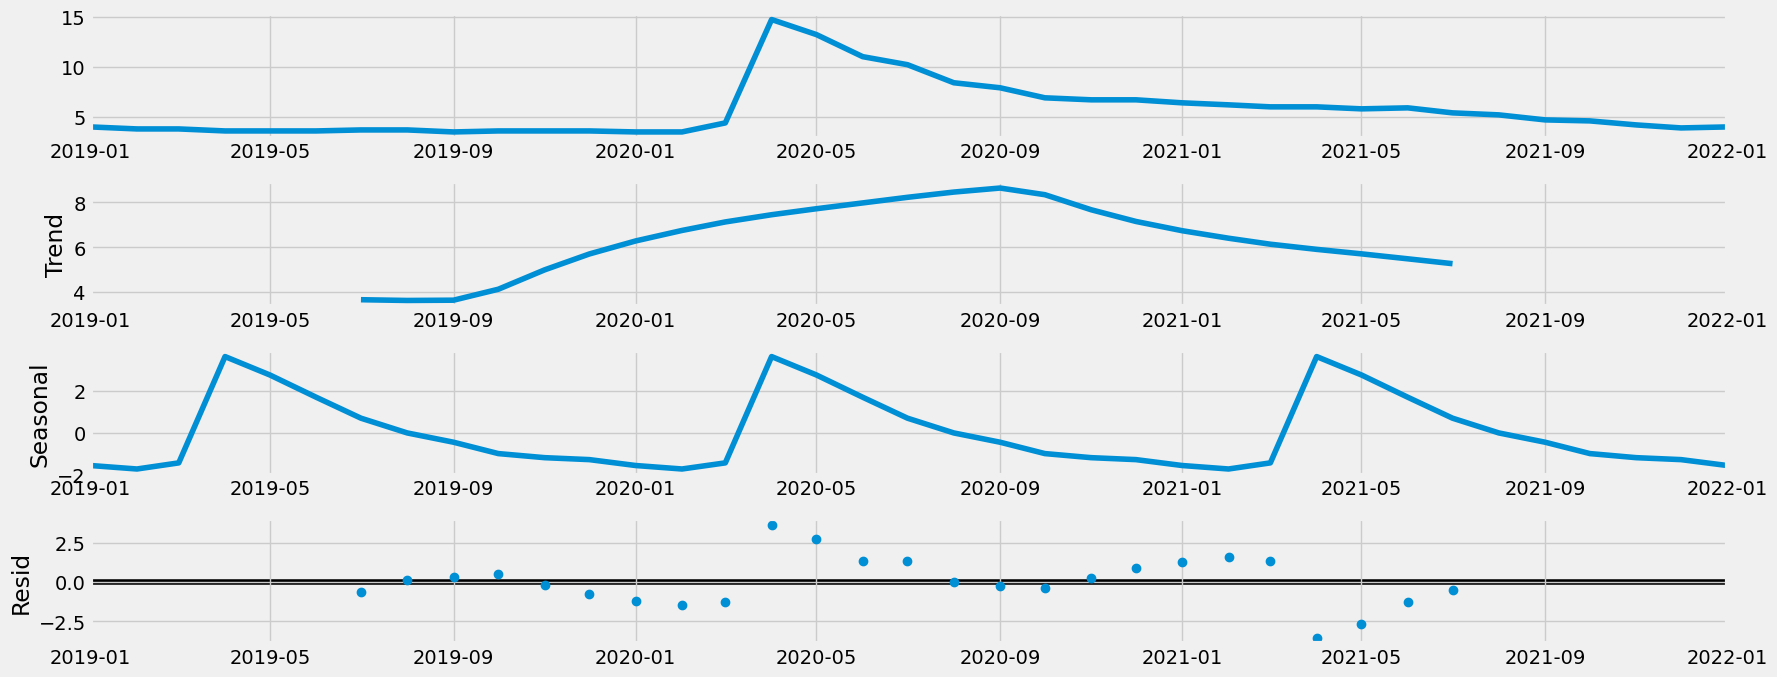

In [21]:
# Plot the separate components

decomposition.plot()
plt.show()

### The first line chart is the data itself.

### The second line chart is the underlying trend. We see a rise beginning at the end of 2019 and a sudden and stead drop after reaching its peak in September 2020.

### The third line chart lets us know that seasonality is present. 

### The fourth line chart is the noise. There are a number of up-and-down deviations, which is consistent with our knowledge of employment uncertainty during the pandamic.

### 4. Testing for stationarity

In [22]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. It is needed to also define a function that prints the correct output from that array

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.060772
p-value                         0.260578
Number of Lags Used             0.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


### Null hypothesis: There is a unit root in the data.

### The p-value of 0.260578 (>0.05) does not indicate a siginificat result.

### The Test Statistic (0.260578) is larger than all critical values.

### Null hypothesis cannot be rejected.

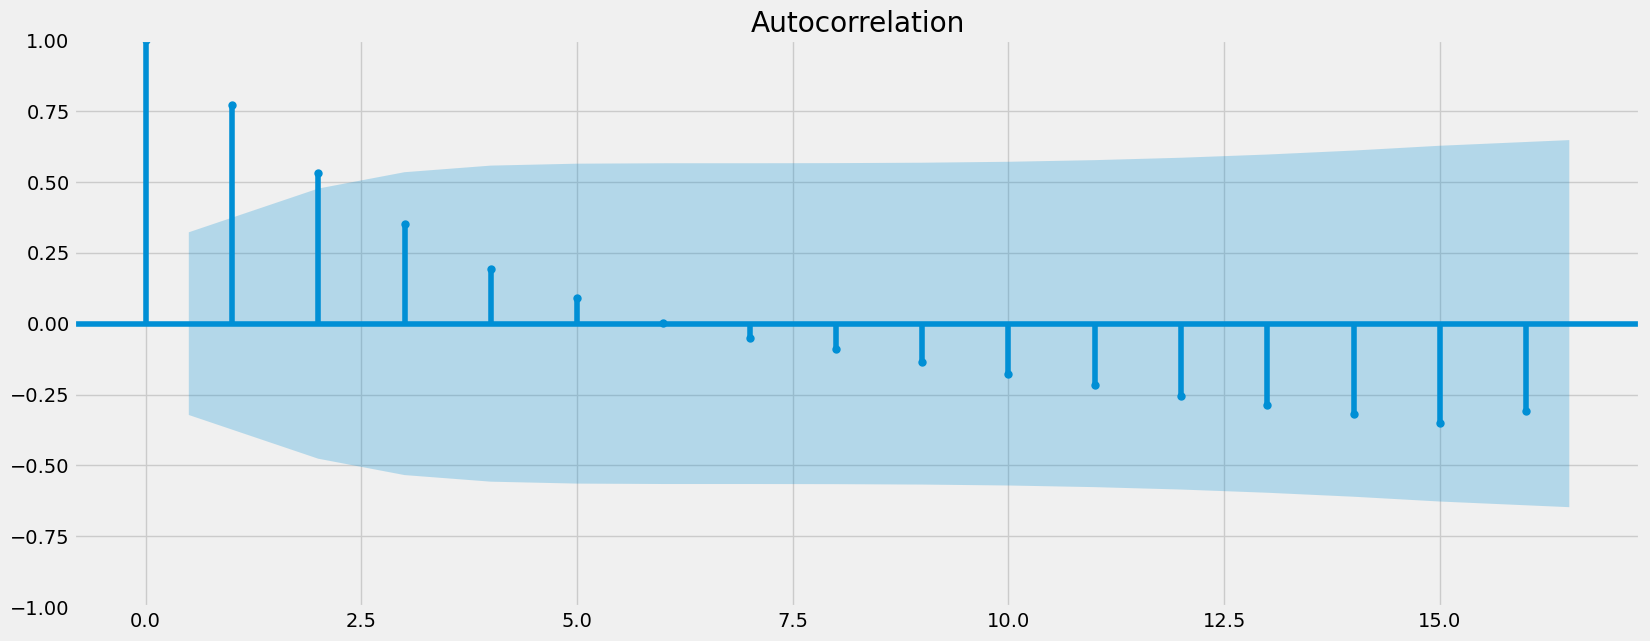

In [23]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 5. Stationarizing the Federal Reserve Economic Data

In [24]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [25]:
data_diff.dropna(inplace = True) # Remove the missing values that came about as a result of the differencing in order to run the Dickey-Fuller test

In [26]:
data_diff.head()

,Value
datetime,
2019-02-01,-0.2
2019-03-01,0.0
2019-04-01,-0.2
2019-05-01,0.0
2019-06-01,0.0


In [27]:
data_diff.columns

Index(['Value'], dtype='object')

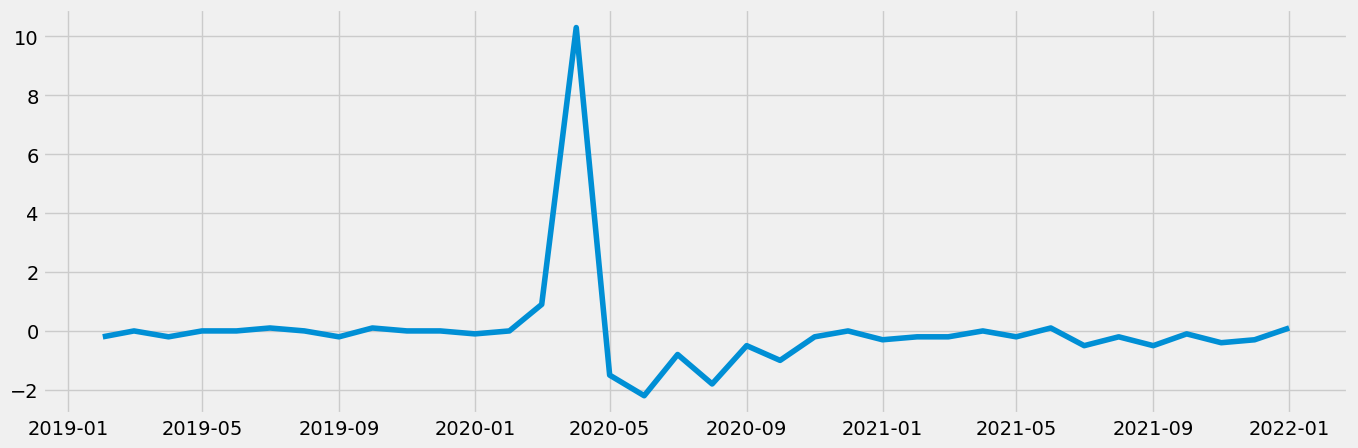

In [28]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [29]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -5.636018
p-value                         0.000001
Number of Lags Used             0.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


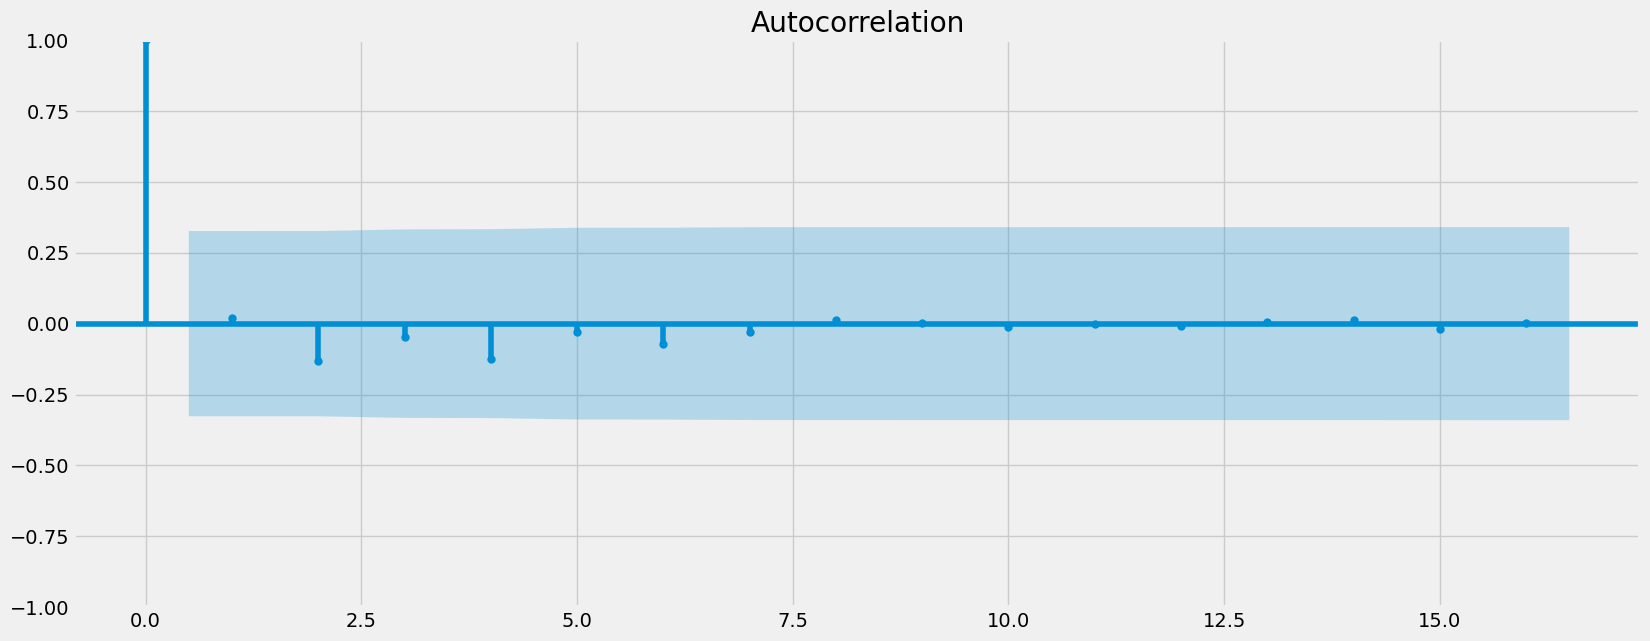

In [30]:
plot_acf(data_diff)
plt.show()

### Null hypothesis: There is a unit root in the data.

### The p-value of 0.000001 (<0.05) indicates a siginificat result.

### The test statistic (-5.636018) is smaller than all Critical values (1%, 5%, 10%)

### The null hypothesis can be rejected.

### Disprove the null = no unit root = stationary data = can proceed with forecast